# 1. Setup

## 1.1 Install Dependencies

In [ ]:
!pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python matplotlib

In [ ]:
pip install opencv-python

## 1.2 Import Dependencies

In [1]:
# Import standard dependencies
import cv2
import os
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
# Import Tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

## 1.3 Set GPU Growth

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus :
    tf.config.experimental.set_memory_growth(gpu,True)

In [ ]:
gpus

In [ ]:
len(gpus)

## 1.3 Create Folder Structures

In [3]:
# Setup paths
POS_PATH = os.path.join('data','positive')
NEG_PATH = os.path.join('data','negative')
ANC_PATH = os.path.join('data','anchor')

In [4]:
# Make Directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'data\\positive'

# Collect Positives and Anchors

## 2.1 Untar Labelled Faces in the Wild Dataset

In [ ]:
#http://vis-www.cs.umass.edu/lfw/

In [ ]:
! gdown --id 1FipUeHj2N7amOT3Op-CfS9F1c5-wSYoz

In [ ]:
# Uncompress Tar Gz labelled Faces in the wild dataset
!tar -xf lfw.tgz

In [5]:
# Move LFW Images to the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

## 2.2 Collect Positive and Anchor Classes

In [6]:
# Import uuid library to generate unique image names
import uuid                  #universally unique identifiers

In [7]:
uuid.uuid1()

UUID('fa4be018-4ed9-11ec-b063-f077c3539228')

In [8]:
'{}.jpg'.format(uuid.uuid1())

'fa50c5ca-4ed9-11ec-8657-f077c3539228.jpg'

In [9]:
os.path.join(ANC_PATH,'{}.jpg'.format(uuid.uuid1()))

'data\\anchor\\fa53f3f6-4ed9-11ec-8206-f077c3539228.jpg'

In [10]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    
    #cut down frame from to 250x250px
    frame = frame[120:120+250,200:200+250,:]
    
    # collect anchors
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create unique file path
        imgname = os.path.join(ANC_PATH,'{}.jpg'.format(uuid.uuid1()))
        # write out another image
        cv2.imwrite(imgname,frame)
    
    # collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create unique file path
        imgname = os.path.join(POS_PATH,'{}.jpg'.format(uuid.uuid1()))
        # write out another image
        cv2.imwrite(imgname,frame)
    
    # Show image back to screen
    cv2.imshow("Image Collection",frame)
    
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
# Release the webcam
cap.release()
# close the image show frame
cv2.destroyAllWindows()

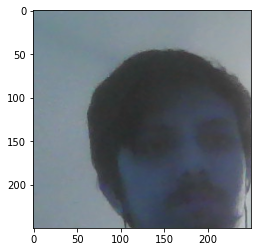

In [11]:
plt.imshow(frame)

In [12]:
frame.shape

(250, 250, 3)

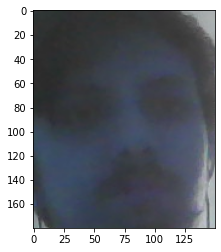

In [13]:
plt.imshow(frame[120-50:370-50,100:450,:])

# 3. Load and Preprocess Image

## 3.1 Get Image Directories

In [14]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'\*jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*jpg').take(300)

In [15]:
dir_test = anchor.as_numpy_iterator()

In [16]:
dir_test.next()

b'data\\anchor\\557e5ec6-3fd6-11ec-b175-fe64114736a4.jpg'

## 3.2 Preprocessing - Scale and Resize

In [17]:
def preprocess(file_path):
    # Read image from file path
    byte_img = tf.io.read_file(file_path)
    # load in the image
    img = tf.io.decode_jpeg(byte_img)
    # Preprocessing the image - resizing image to 100x100x3
    img = tf.image.resize(img,(100,100))
    # Scaling the image between 0 and 1
    img = img/255.0
    return img

In [18]:
preprocess('data\\anchor\\557e5ec6-3fd6-11ec-b175-fe64114736a4.jpg')

<tf.Tensor: shape=(100, 100, 3), dtype=float32, numpy=
array([[[0.5992647 , 0.5718137 , 0.5012255 ],
        [0.5973039 , 0.5718137 , 0.5002451 ],
        [0.6019608 , 0.58235294, 0.50784314],
        ...,
        [0.7115196 , 0.7115196 , 0.6723039 ],
        [0.7107843 , 0.7107843 , 0.67156863],
        [0.70980394, 0.70980394, 0.67058825]],

       [[0.59313726, 0.5735294 , 0.4990196 ],
        [0.59313726, 0.5735294 , 0.4990196 ],
        [0.59093136, 0.5713235 , 0.4968137 ],
        ...,
        [0.7127451 , 0.7127451 , 0.6735294 ],
        [0.70955884, 0.70955884, 0.67034316],
        [0.70980394, 0.70980394, 0.67058825]],

       [[0.59607846, 0.5764706 , 0.5019608 ],
        [0.6019608 , 0.58235294, 0.50784314],
        [0.6117647 , 0.5877451 , 0.5154412 ],
        ...,
        [0.70710784, 0.70710784, 0.66789216],
        [0.70416665, 0.70416665, 0.66495097],
        [0.70686275, 0.70686275, 0.66764706]],

       ...,

       [[0.14632353, 0.19828431, 0.23063725],
        [0.14

In [19]:
img = preprocess('data\\anchor\\557e5ec6-3fd6-11ec-b175-fe64114736a4.jpg')

In [20]:
img.numpy().min()

0.07132353

In [21]:
img.numpy().max()

0.7230392

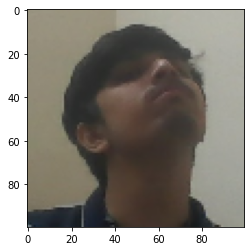

In [22]:
plt.imshow(img)

## 3.3 Create Labelled Dataset

In [23]:
tf.ones_like(1)

<tf.Tensor: shape=(), dtype=int32, numpy=1>

In [24]:
tf.ones_like([1,1,34.43,344.2])

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([1., 1., 1., 1.], dtype=float32)>

(anchor, positive) => 1,1,1,1

(anchor,negative) => 0,0,0,0

In [25]:
print(tf.ones(len(anchor)))
print(tf.ones(len(anchor)).shape)

tf.Tensor(
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.], shape=(300,), dtype=float32)
(300,)


In [26]:
positives = tf.data.Dataset.zip((anchor,positive,tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor,negative,tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [27]:
samples = data.as_numpy_iterator()

In [28]:
example = samples.next()

In [29]:
example

(b'data\\anchor\\4ad7cce7-3fd7-11ec-890f-fe64114736a4.jpg',
 b'data\\positive\\d72cc81f-3fd7-11ec-9a4a-fe64114736a4.jpg',
 1.0)

## 3.4 Build Train and Test Partition

In [30]:
def preprocess_twin(input_img, validation_img, label):
    return (preprocess(input_img),preprocess(validation_img),label)

In [31]:
preprocess_twin(*example)

(<tf.Tensor: shape=(100, 100, 3), dtype=float32, numpy=
 array([[[0.72083336, 0.7247549 , 0.6933824 ],
         [0.72156864, 0.7254902 , 0.69411767],
         [0.72156864, 0.7254902 , 0.69411767],
         ...,
         [0.49485293, 0.4870098 , 0.49093136],
         [0.4970588 , 0.48333332, 0.4872549 ],
         [0.49803922, 0.48235294, 0.4862745 ]],
 
        [[0.7176471 , 0.7235294 , 0.6931372 ],
         [0.72083336, 0.7262255 , 0.6960784 ],
         [0.71936274, 0.7232843 , 0.69240195],
         ...,
         [0.49068627, 0.48235294, 0.4862745 ],
         [0.49656862, 0.48235294, 0.4862745 ],
         [0.49803922, 0.48235294, 0.4862745 ]],
 
        [[0.7205882 , 0.7323529 , 0.70490193],
         [0.72181374, 0.73308825, 0.7058824 ],
         [0.7240196 , 0.7294118 , 0.6992647 ],
         ...,
         [0.4882353 , 0.47843137, 0.48235294],
         [0.49411765, 0.47843137, 0.48235294],
         [0.49803922, 0.48235294, 0.4862745 ]],
 
        ...,
 
        [[0.65588236, 0.6627451 

In [32]:
res = preprocess_twin(*example)      # we used * to unpack

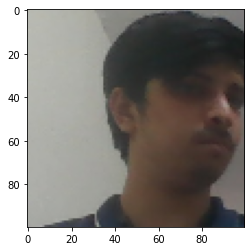

In [33]:
plt.imshow(res[0])

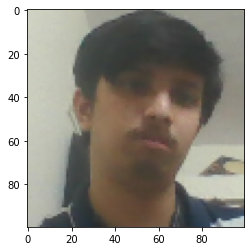

In [34]:
plt.imshow(res[1])

In [35]:
res[2]

1.0

In [36]:
# Build Dataloder Pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [37]:
data

<ShuffleDataset shapes: ((100, 100, None), (100, 100, None), ()), types: (tf.float32, tf.float32, tf.float32)>

In [38]:
samples = data.as_numpy_iterator()

In [40]:
samp = samples.next()

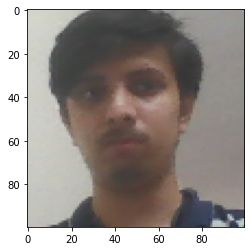

In [41]:
plt.imshow(samp[0])

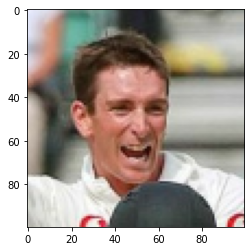

In [42]:
plt.imshow(samp[1])

In [43]:
print(samp[2])

0.0


In [44]:
samp = samples.next()

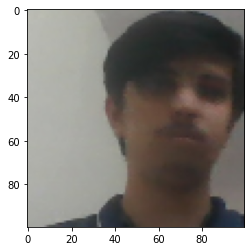

In [45]:
plt.imshow(samp[0])

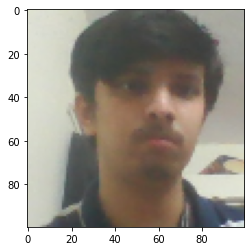

In [46]:
plt.imshow(samp[1])

In [47]:
print(samp[2])

1.0


In [49]:
print(len(data))
print(len(data)*0.7)

600
420.0


In [50]:
data

<ShuffleDataset shapes: ((100, 100, None), (100, 100, None), ()), types: (tf.float32, tf.float32, tf.float32)>

In [51]:
# Training Partition
train_data = data.take(round(len(data)*0.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [52]:
train_data             # here train data has 4 dimension , while data has 3 dimension , because we also have added batchs , so 1st dim in batchb

<PrefetchDataset shapes: ((None, 100, 100, None), (None, 100, 100, None), (None,)), types: (tf.float32, tf.float32, tf.float32)>

In [53]:
train_samples = train_data.as_numpy_iterator()

In [54]:
train_sample = train_samples.next()

In [55]:
train_sample

(array([[[[0.8039216 , 0.80784315, 0.7882353 ],
          [0.8041667 , 0.80808824, 0.7884804 ],
          [0.80490196, 0.8088235 , 0.7884804 ],
          ...,
          [0.7875    , 0.81102943, 0.76740193],
          [0.785049  , 0.7997549 , 0.7620098 ],
          [0.7860294 , 0.7977941 , 0.7610294 ]],
 
         [[0.80784315, 0.80784315, 0.8039216 ],
          [0.8036765 , 0.8036765 , 0.7977941 ],
          [0.7992647 , 0.7992647 , 0.79338235],
          ...,
          [0.7877451 , 0.8014706 , 0.7473039 ],
          [0.7862745 , 0.8       , 0.74509805],
          [0.7852941 , 0.79901963, 0.7441176 ]],
 
         [[0.8041667 , 0.8041667 , 0.8120098 ],
          [0.8007353 , 0.8007353 , 0.8066176 ],
          [0.7970588 , 0.7970588 , 0.7970588 ],
          ...,
          [0.7852941 , 0.79313725, 0.7411765 ],
          [0.7882353 , 0.79607844, 0.7411765 ],
          [0.7921569 , 0.8       , 0.74509805]],
 
         ...,
 
         [[0.6188725 , 0.6188725 , 0.6110294 ],
          [0.62352

In [56]:
len(train_sample[0])

16

In [57]:
# Testing Partition
test_data = data.skip(round(len(data)*0.7))
test_data = test_data.take(round(len(data)*0.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# 4. Model Engineering

## 4.1 Build Embedding Layer

In [58]:
inp = Input(shape=(100,100,3),name='input_image')

In [59]:
inp

<KerasTensor: shape=(None, 100, 100, 3) dtype=float32 (created by layer 'input_image')>

In [60]:
c1 = Conv2D(64,(10,10),activation='relu')(inp)

In [61]:
c1

<KerasTensor: shape=(None, 91, 91, 64) dtype=float32 (created by layer 'conv2d')>

In [62]:
def make_embedding():
    inp = Input(shape=(100,100,3),name='input_image')
    
    # first block
    c1 = Conv2D(64, (10,10),activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2),padding='same')(c1)
    
    # second block
    c2 = Conv2D(128, (7,7),activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2),padding='same')(c2)
    
    # hird block
    c3 = Conv2D(128, (4,4),activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2),padding='same')(c3)
    
    # final embedding block
    c4 = Conv2D(256, (4,4),activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    return Model(inputs=[inp],outputs=[d1], name='embedding')

In [63]:
embedding = make_embedding()

In [64]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 17, 17, 128)       26

## 4.2 Build Distance Layer

In [65]:
# Siamese Distance class
class L1Dist(Layer):
    # Init method - inheritance
    def __init__(self,**kwargs):
        super().__init__()
    # Similarity calculation
    def call(self,input_embedding,validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

## 4.3 Make Siamese Model

In [66]:
input_image = Input(name='input_img',shape=(100,100,3))

In [67]:
embedding(input_image)

<KerasTensor: shape=(None, 4096) dtype=float32 (created by layer 'embedding')>

In [68]:
inp_embedding = embedding(input_image)

In [69]:
validation_image = Input(name='validation_img',shape=(100,100,3))

In [70]:
embedding(validation_image)

<KerasTensor: shape=(None, 4096) dtype=float32 (created by layer 'embedding')>

In [71]:
val_embedding = embedding(input_image)

In [72]:
siamese_layer = L1Dist()

In [73]:
siamese_layer(inp_embedding, val_embedding)

<KerasTensor: shape=(None, 4096) dtype=float32 (created by layer 'l1_dist')>

In [74]:
def make_siamese_model():
    
    input_image = Input(name='input_img',shape=(100,100,3))
    validation_image = Input(name='validation_img',shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image),embedding(validation_image))
    
    # Classification Layer
    classifier = Dense(1,activation='sigmoid')(distances)
    
    return Model(inputs = [input_image,validation_image], outputs = classifier,name='SiameseNetwork')
    

In [75]:
siamese_model = make_siamese_model()

In [76]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

# 5. Training

## 5.1 Setup Loss and Optimizer

In [77]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [78]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-4)

## 5.2 Establish Checkpoints

In [79]:
checkpoint_dir = '.\training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir,'ckpt')
checkpoint = tf.train.Checkpoint(opt = opt, siamese_model = siamese_model)

## 5.3 Build Train Step Function

In [80]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

## 5.4 Build Training Loop

while the train_step function was focused on training for one batch, the loop here will be used to iterate over every batch in the dataset

In [81]:
def train(data,EPOCHS):
    # Loops through epochs
    for epoch in range(1,EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch,EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))      # ProgressBar
    
        # Loops through each batch
        for idx, batch in enumerate(data):
            # run train step here
            train_step(batch)
            progbar.update(idx+1)
            
        # Save checkpoints
        if (epoch % 10 == 0) :
            checkpoint.save(file_prefix=checkpoint_prefix)
            

## 5.5 Train the Model

In [82]:
EPOCHS = 50

In [ ]:
train(train_data,EPOCHS)

# 6. Evaluate Model

## 6.1 Import Metrics

In [85]:
from tensorflow.keras.metrics import Precision, Recall

In [86]:
# Get a batch of data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [87]:
test_input

array([[[[0.74485296, 0.7409314 , 0.6625    ],
         [0.7411765 , 0.7372549 , 0.65882355],
         [0.7345588 , 0.73063725, 0.65955883],
         ...,
         [0.50490195, 0.49313724, 0.42647058],
         [0.4997549 , 0.4879902 , 0.42132354],
         [0.5107843 , 0.4872549 , 0.4245098 ]],

        [[0.7409314 , 0.7389706 , 0.67034316],
         [0.7345588 , 0.7296569 , 0.6718137 ],
         [0.72843134, 0.7235294 , 0.66568625],
         ...,
         [0.5002451 , 0.4875    , 0.43161765],
         [0.49509802, 0.48235294, 0.42647058],
         [0.5029412 , 0.48137254, 0.42843136]],

        [[0.7252451 , 0.7291667 , 0.6723039 ],
         [0.7296569 , 0.73357844, 0.6786765 ],
         [0.7323529 , 0.7362745 , 0.6813725 ],
         ...,
         [0.5009804 , 0.4852941 , 0.43823528],
         [0.49730393, 0.48161766, 0.4345588 ],
         [0.49411765, 0.47843137, 0.43137255]],

        ...,

        [[0.65882355, 0.6647059 , 0.622549  ],
         [0.6629902 , 0.66887254, 0.6247549 ]

In [88]:
test_val

array([[[[7.72549033e-01, 7.80392170e-01, 7.25490212e-01],
         [7.68627465e-01, 7.76470602e-01, 7.21568644e-01],
         [7.61764705e-01, 7.69607842e-01, 7.14705884e-01],
         ...,
         [5.57843149e-01, 5.68627477e-01, 5.31372547e-01],
         [5.60784340e-01, 5.68627477e-01, 5.25490224e-01],
         [5.59803903e-01, 5.67647040e-01, 5.24509788e-01]],

        [[7.72549033e-01, 7.80392170e-01, 7.25490212e-01],
         [7.71813750e-01, 7.79656887e-01, 7.24754930e-01],
         [7.66421556e-01, 7.74264693e-01, 7.19362736e-01],
         ...,
         [5.52941203e-01, 5.63235283e-01, 5.30637264e-01],
         [5.60294092e-01, 5.64705908e-01, 5.35049021e-01],
         [5.56862772e-01, 5.60784340e-01, 5.29411793e-01]],

        [[7.72549033e-01, 7.80392170e-01, 7.28431344e-01],
         [7.72549033e-01, 7.80392170e-01, 7.28431344e-01],
         [7.71813750e-01, 7.79656887e-01, 7.27696061e-01],
         ...,
         [5.47058821e-01, 5.55882335e-01, 5.34313738e-01],
         [

In [89]:
 y_true

array([1., 1., 0., 1., 0., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 1.],
      dtype=float32)

## 6.2 Make Predictions

In [ ]:
# make predictions
y_hat = siamese_model.predict([test_input, test_val])
y_hat

In [ ]:
# post processing the results
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

In [ ]:
y_true

## 6.3 Calculate Metrics

In [ ]:
# Creating metric object
m = Recall()

# Calculating the recall value
m.update_state(y_true, y_hat)

# return recall result
m.result().numpy()

In [ ]:
# Creating metric object
m = Precision()

# Calculating the recall value
m.update_state(y_true, y_hat)

# Return precision result 
m.result().numpy()

## 6.4 Visualize Results

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(test_input[15])
plt.subplot(1,2,2)
plt.imshow(test_val[15])

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(test_input[10])
plt.subplot(1,2,2)
plt.imshow(test_val[10])

# 7. Save Model

In [ ]:
# Save Weights
siamese_model.save('SiameseModel.h5')

In [90]:
# Reload Model
model = tf.keras.models.load_model('SiameseModel.h5', custom_objects={'L1Dist' : L1Dist, 'BinaryCrossEntropy' : tf.losses.BinaryCrossentropy})

In [92]:
# make prediction with reloaded models
model.predict([test_input,test_val])

array([[1.0000000e+00],
       [9.9962699e-01],
       [7.7944151e-08],
       [1.0000000e+00],
       [3.5353604e-08],
       [3.0825950e-07],
       [9.9999851e-01],
       [9.9999940e-01],
       [2.7863337e-08],
       [1.0000000e+00],
       [3.2297386e-08],
       [9.9999696e-01],
       [1.1925203e-08],
       [9.9999714e-01],
       [3.4916192e-07],
       [1.0000000e+00]], dtype=float32)

In [94]:
# make predictions
y_hat = model.predict([test_input, test_val])
y_hat

array([[1.0000000e+00],
       [9.9962699e-01],
       [7.7944151e-08],
       [1.0000000e+00],
       [3.5353604e-08],
       [3.0825950e-07],
       [9.9999851e-01],
       [9.9999940e-01],
       [2.7863337e-08],
       [1.0000000e+00],
       [3.2297386e-08],
       [9.9999696e-01],
       [1.1925203e-08],
       [9.9999714e-01],
       [3.4916192e-07],
       [1.0000000e+00]], dtype=float32)

In [95]:
# post processing the results
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1]

In [96]:
y_true

array([1., 1., 0., 1., 0., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 1.],
      dtype=float32)

In [97]:
# Creating metric object
m = Recall()

# Calculating the recall value
m.update_state(y_true, y_hat)

# return recall result
m.result().numpy()

1.0

In [98]:
# Creating metric object
m = Precision()

# Calculating the recall value
m.update_state(y_true, y_hat)

# Return precision result 
m.result().numpy()

1.0

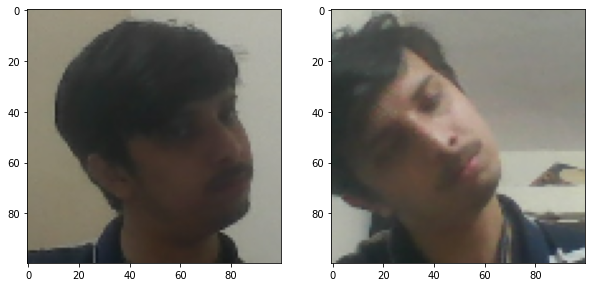

In [99]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(test_input[15])
plt.subplot(1,2,2)
plt.imshow(test_val[15])

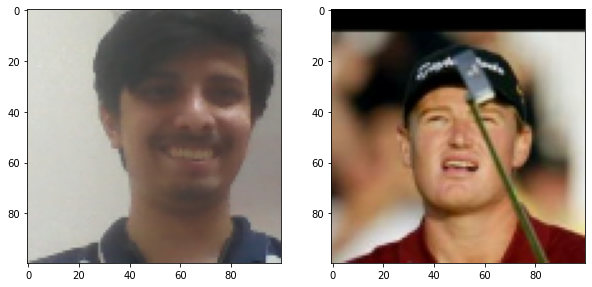

In [100]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(test_input[10])
plt.subplot(1,2,2)
plt.imshow(test_val[10])

# 8. Real Time Test 

## 8.1 Verification Function

In [101]:
os.listdir(os.path.join('application_data', 'verification_images'))

['03c3f2d9-4ea2-11ec-bf68-f077c3539228.jpg',
 '0420c054-4ea2-11ec-ae87-f077c3539228.jpg',
 '04b5e381-4ea2-11ec-bbdf-f077c3539228.jpg',
 '3ac8c88e-4ea5-11ec-a4a7-f077c3539228.jpg',
 '3b3b1afd-4ea5-11ec-87f3-f077c3539228.jpg',
 '7f7df843-3fd7-11ec-b702-fe64114736a4.jpg',
 '7fa616b3-3fd7-11ec-8622-fe64114736a4.jpg',
 '7fb46cae-3fd7-11ec-97cd-fe64114736a4.jpg',
 '811d0bad-3fd7-11ec-bfa4-fe64114736a4.jpg',
 '812d5f1c-3fd7-11ec-b8b0-fe64114736a4.jpg',
 '817f4a98-3fd7-11ec-9c3f-fe64114736a4.jpg',
 '827eacce-3fd7-11ec-bbb8-fe64114736a4.jpg',
 '831c37c5-3fd7-11ec-8da4-fe64114736a4.jpg',
 '832b7077-3fd7-11ec-91b3-fe64114736a4.jpg',
 '834cb94c-3fd7-11ec-898c-fe64114736a4.jpg',
 '836c43d2-3fd7-11ec-9d6a-fe64114736a4.jpg',
 '839a3f6a-3fd7-11ec-a0bf-fe64114736a4.jpg',
 '870d2df6-3fd7-11ec-b7d5-fe64114736a4.jpg',
 '8d5634c3-3fd7-11ec-b9fa-fe64114736a4.jpg',
 '8d8053ed-3fd7-11ec-b807-fe64114736a4.jpg',
 '8e8b36ad-3fd7-11ec-b0fe-fe64114736a4.jpg',
 '8face2d7-3fd7-11ec-a61b-fe64114736a4.jpg',
 '90d25363

In [102]:
os.path.join('application_data', 'input_image', 'input_image.jpg')

'application_data\\input_image\\input_image.jpg'

In [103]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

application_data\verification_images\03c3f2d9-4ea2-11ec-bf68-f077c3539228.jpg
application_data\verification_images\0420c054-4ea2-11ec-ae87-f077c3539228.jpg
application_data\verification_images\04b5e381-4ea2-11ec-bbdf-f077c3539228.jpg
application_data\verification_images\3ac8c88e-4ea5-11ec-a4a7-f077c3539228.jpg
application_data\verification_images\3b3b1afd-4ea5-11ec-87f3-f077c3539228.jpg
application_data\verification_images\7f7df843-3fd7-11ec-b702-fe64114736a4.jpg
application_data\verification_images\7fa616b3-3fd7-11ec-8622-fe64114736a4.jpg
application_data\verification_images\7fb46cae-3fd7-11ec-97cd-fe64114736a4.jpg
application_data\verification_images\811d0bad-3fd7-11ec-bfa4-fe64114736a4.jpg
application_data\verification_images\812d5f1c-3fd7-11ec-b8b0-fe64114736a4.jpg
application_data\verification_images\817f4a98-3fd7-11ec-9c3f-fe64114736a4.jpg
application_data\verification_images\827eacce-3fd7-11ec-bbb8-fe64114736a4.jpg
application_data\verification_images\831c37c5-3fd7-11ec-8da4-fe6

In [104]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

## 8.2 OpenCV Real Time Verification

In [112]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
       # Run verification
        results, verified = verify(model, 0.9, 0.7)
        print(verified) 
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

True
False


In [113]:
np.squeeze(results) > 0.5

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

In [115]:
np.sum(np.squeeze(results) > 0.9)

30